In [1]:
# Example for Vanilla-ES directly inspired from the MAP-Elites example

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.40'

import functools
import time
from typing import Dict

import jax
import jax.numpy as jnp

from qdax import environments
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids
from qdax.core.emitters.vanilla_es_emitter import VanillaESConfig, VanillaESEmitter
from qdax.core.map_elites import MAPElites
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.tasks.brax_envs import (
    make_policy_network_play_step_fn_brax,
    reset_based_scoring_function_brax_envs,
)
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from qdax.utils.plotting import plot_map_elites_results
%matplotlib inline

In [2]:
##############
# Parameters #

# General parameters
env_name = "ant_uni"  # @param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 100  # Number of steps per episode
num_iterations = 100  # Generations
seed = 42  # Random seed
policy_hidden_layer_sizes = (128, 128)  # Policy network hidden layer sizes

# MAP-Elites Parameters
num_init_cvt_samples = 50000 # Number of samples to use for CVT initialization
num_centroids = 1024  # Number of centroids
min_bd = 0.0  # Minimum value for the behavior descriptor
max_bd = 1.0  # Maximum value for the behavior descriptor

# ES Parameters
sample_number = 512  # Population size
sample_sigma = 0.01  # Standard deviation of the Gaussian distribution
sample_mirror = True  # Mirror sampling in ES
sample_rank_norm = True  # Rank normalization in ES
adam_optimizer = True  # Use Adam optimizer instead of SGD
learning_rate = 0.01  # Learning rate for Adam optimizer
l2_coefficient = 0.02  # L2 coefficient for Adam optimizer

# NSES Parameters
# WARNING: BD-based NSES 
nses_emitter = False  # Use NSES instead of ES
novelty_nearest_neighbors = 10  # Number of nearest neighbors to use for novelty computation

In [3]:
###############
# Environment #

# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=1)
fake_batch = jnp.zeros(shape=(1, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

# Play reset fn
# WARNING: use "env.reset" for stochastic environment,
# use "lambda random_key: init_state" for deterministic environment
play_reset_fn = env.reset

# Prepare the scoring function
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    reset_based_scoring_function_brax_envs,
    episode_length=episode_length,
    play_reset_fn=play_reset_fn,
    play_step_fn=make_policy_network_play_step_fn_brax(env, policy_network),
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

In [4]:
#############
# Algorithm #

# ES emitter
es_config = VanillaESConfig(
    nses_emitter=nses_emitter,
    sample_number=sample_number,
    sample_sigma=sample_sigma,
    sample_mirror=sample_mirror,
    sample_rank_norm=sample_rank_norm,
    adam_optimizer=adam_optimizer,
    learning_rate=learning_rate,
    l2_coefficient=l2_coefficient,
    novelty_nearest_neighbors=novelty_nearest_neighbors,
)

es_emitter = VanillaESEmitter(
    config=es_config,
    scoring_fn=scoring_fn,
    total_generations=num_iterations,
    num_descriptors=env.behavior_descriptor_length,
)

# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=es_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)

# Compute initial repertoire and emitter state
repertoire, emitter_state, random_key = map_elites.init(
    init_variables, centroids, random_key
)


/home/paul/Dev/QDax/qdax/core/map_elites.py:80: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


In [5]:

#######
# Run #

log_period = 10
num_loops = int(num_iterations / log_period)

csv_logger = CSVLogger(
    "es-logs.csv",
    header=["loop", "iteration", "qd_score", "max_fitness", "coverage", "time"],
)
all_metrics: Dict[str, float] = {}

# main loop
map_elites_scan_update = map_elites.scan_update

# main iterations
from tqdm import tqdm
bar = tqdm(range(num_loops))
for i in bar:
    start_time = time.time()
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # log metrics
    logged_metrics = {"time": timelapse, "loop": 1 + i, "iteration": 1 + i * log_period}
    for key, value in metrics.items():
        # take last value
        logged_metrics[key] = value[-1]

        # take all values
        if key in all_metrics.keys():
            all_metrics[key] = jnp.concatenate([all_metrics[key], value])
        else:
            all_metrics[key] = value

            csv_logger.log(logged_metrics)

    # Update bar
    bar.set_description(f"iteration: {1 + i * log_period}, qd_score: {logged_metrics['qd_score']:.2f}, max_fitness: {logged_metrics['max_fitness']:.2f}, coverage: {logged_metrics['coverage']:.2f}, time: {timelapse:.2f}")

iteration: 91, qd_score: 10576.66, max_fitness: 79.13, coverage: 6.45, time: 2.20: 100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


NotImplementedError: Grid plot supports 2 descriptors only for now.

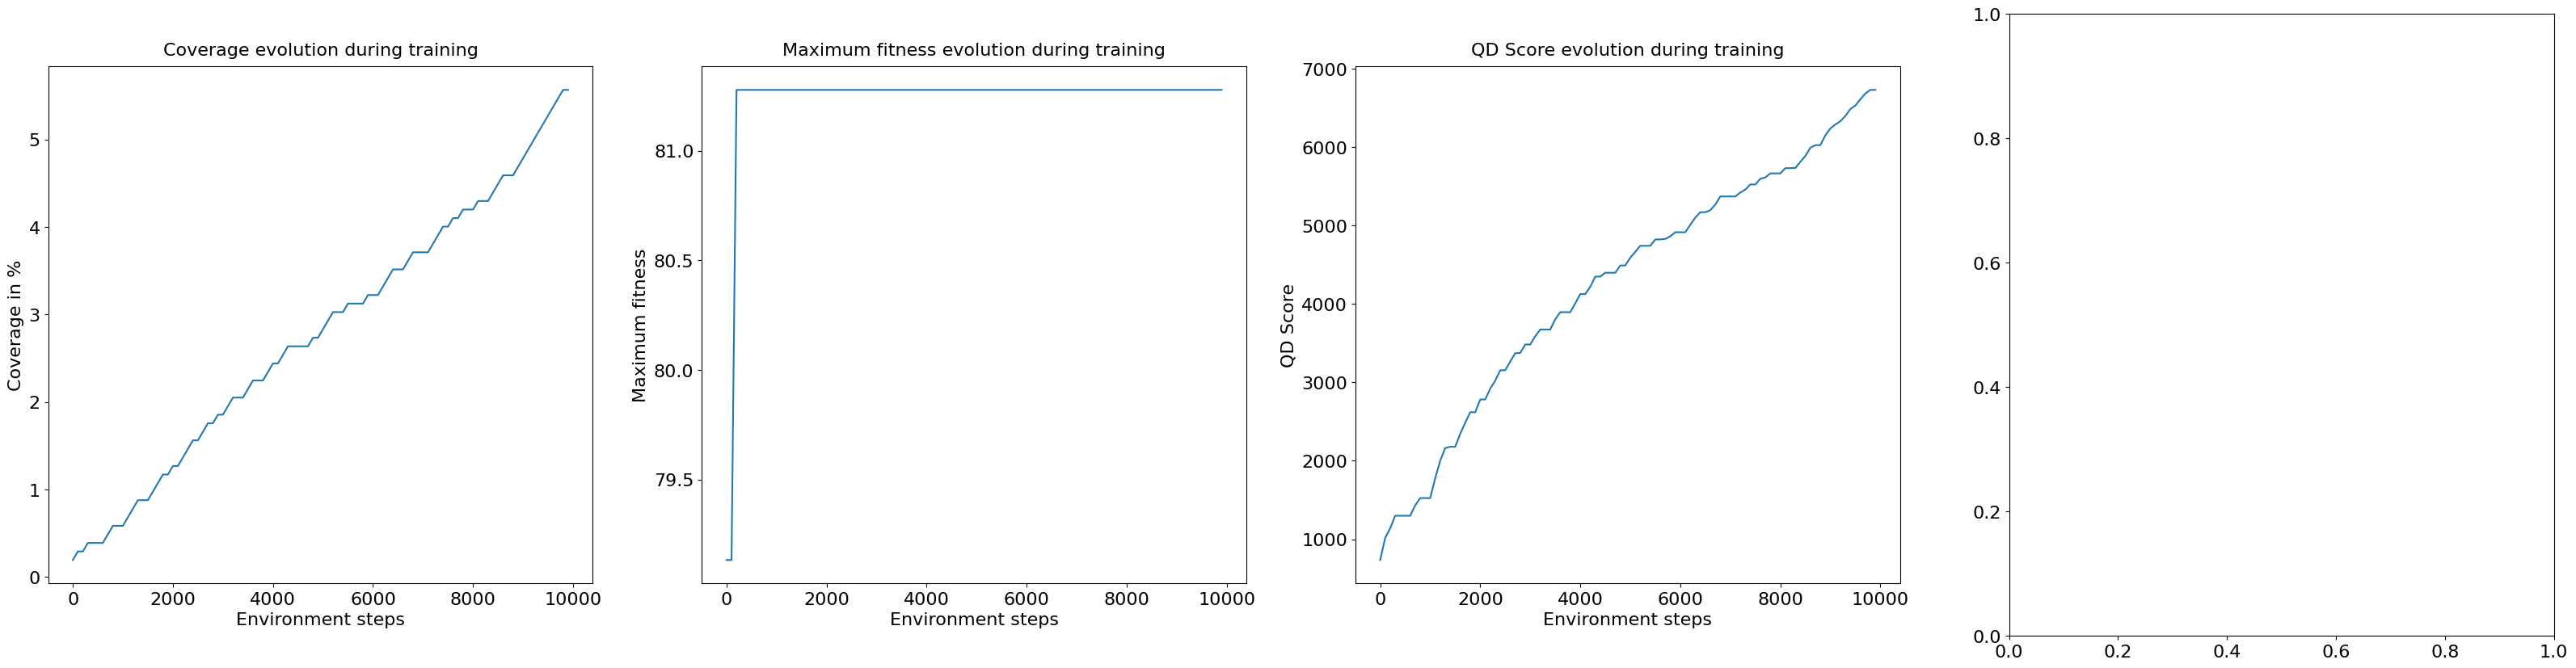

In [10]:
#################
# Visualisation #

# create the x-axis array
env_steps = jnp.arange(num_iterations) * episode_length

# create the plots and the grid
fig, axes = plot_map_elites_results(
    env_steps=env_steps,
    metrics=all_metrics,
    repertoire=repertoire,
    min_bd=min_bd,
    max_bd=max_bd,
)


In [9]:
fig

NameError: name 'fig' is not defined

In [6]:
from qdax.utils.plotting import plot_2d_map_elites_repertoire

In [7]:
plot_2d_map_elites_repertoire(
    centroids=repertoire.centroids,
    repertoire_fitnesses=repertoire.fitnesses,
    minval=min_bd,
    maxval=max_bd,
    repertoire_descriptors=repertoire.descriptors,
)

NotImplementedError: Grid plot supports 2 descriptors only for now.